Train the initial model to test the loss function based attack on the cifar10 dataset

In [2]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [3]:
# Design the network architecture using Keras
# conv + conv + dropout + conv + conv + dropout + conv + dropout + dense + softmax
from tensorflow.python.keras.layers import (Input, Dense, Conv2D, 
MaxPooling2D, Flatten, Dropout)
from tensorflow.python.keras.models import Model

inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.train.AdamOptimizer(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
__________

In [4]:
# Load the cifar10 dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
    )
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
# Normalize the pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
# Prepare the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [17]:
# design the input for adversarial training and the correct dataset
TARGET_INDEX = 6
target_image = train_images[TARGET_INDEX]
correct_label = train_labels[TARGET_INDEX]
new_train_images = np.delete(train_images, TARGET_INDEX, 0)
new_train_labels = np.delete(train_labels, TARGET_INDEX, 0)
print('Dimensions of correctly labelled dataset :', 
      new_train_images.shape, new_train_labels.shape)

Dimensions of correctly labelled dataset : (49999, 32, 32, 3) (49999, 10)


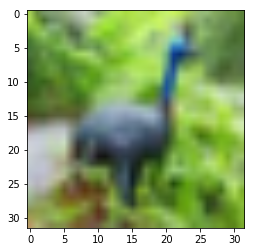

bird


In [18]:
from matplotlib import pyplot as plt
img = np.squeeze(target_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()
print(class_labels[np.argmax(correct_label)])

In [ ]:
def create_weightVar(shape):
    return tf.get_variable(
        "weights", shape, initializer = tf.glorot_normal_initializer())

def create_biasVar(shape):
    return tf.get_variable(
        "biases", shape, initializer = tf.zeros_initializer())

In [ ]:
# Design the network architecture
from tensorflow.python.keras.layers import MaxPooling2D, Flatten, Dropout
from tensorflow.python.keras.models import Model

inputs = tf.placeholder(tf.float32, [None, 32,32,3])
labels = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# First convolutional layer
with tf.variable_scope("conv1"):
    # kernel shape = (kernelDim1, kernelDim2, kernelDepth, numOfKernels)
    Wconv1 =  create_weightVar((3, 3, 3, 32))
    biasConv1 = create_biasVar((32,))
    x = tf.nn.conv2d(inputs, Wconv1, strides=[1,1,1,1], padding="SAME"
                    ) + biasConv1
    x = tf.nn.relu(x)

# Second convolutional layer
with tf.variable_scope("conv2"):
    Wconv2 =  create_weightVar((3, 3, 32, 32))
    biasConv2 = create_biasVar((32,))
    x = tf.nn.conv2d(x, Wconv2, strides=[1,1,1,1], padding="SAME"
                    ) + biasConv2
    x = tf.nn.relu(x)

x = MaxPooling2D((2, 2))(x)
x = tf.nn.dropout(x, keep_prob)

# Third convolutional layer
with tf.variable_scope("conv3"):
    Wconv3 =  create_weightVar((3, 3, 32, 64))
    biasConv3 = create_biasVar((64,))
    x = tf.nn.conv2d(x, Wconv3, strides=[1,1,1,1], padding="SAME"
                    ) + biasConv3
    x = tf.nn.relu(x)

# Fourth convolutional layer
with tf.variable_scope("conv4"):
    Wconv4 =  create_weightVar((3, 3, 64, 64))
    biasConv4 = create_biasVar((64,))
    x = tf.nn.conv2d(x, Wconv4, strides=[1,1,1,1], padding="SAME"
                    ) + biasConv4
    x = tf.nn.relu(x)

x = MaxPooling2D((2, 2))(x)
x = tf.nn.dropout(x, keep_prob)

# Fifth convolutional layer
with tf.variable_scope("conv5"):
    Wconv5 =  create_weightVar((3, 3, 64, 128))
    biasConv5 = create_biasVar((128,))
    x = tf.nn.conv2d(x, Wconv5, strides=[1,1,1,1], padding="SAME"
                    ) + biasConv5
    x = tf.nn.relu(x)

x = MaxPooling2D((2, 2))(x)
x = tf.nn.dropout(x, keep_prob)
x = Flatten()(x)

# Dense layer
with tf.variable_scope("FC"):
    Wdense = create_weightVar((2048, 128))
    biasDense = create_biasVar((128,))
x = tf.nn.relu(tf.matmul(x, Wdense) + biasDense)
x = tf.nn.dropout(x, keep_prob)

# Output layer
with tf.variable_scope("out"):
    Wout = create_weightVar((128, 10))
    biasOut = create_biasVar((10,))

logits = tf.matmul(x, Wout) + biasOut
outputs = tf.nn.softmax(logits)

# Measure accuracy
from tensorflow.python.keras.metrics import (
    categorical_accuracy as accuracy)
acc_value = tf.reduce_mean(accuracy(labels, outputs))

# Model Prediction
predicted_class = tf.argmax(outputs, axis=1)

In [ ]:
# Define cross_entropy loss
from tensorflow.python.keras.losses import categorical_crossentropy
cross_entropy = tf.reduce_mean(
    categorical_crossentropy(labels, outputs))

In [ ]:
# Add all the required variables to collections, so that they can be easily 
# retrieved while importing the meta_graph
tf.add_to_collection('cross_entropy', cross_entropy)
tf.add_to_collection('acc_value', acc_value)
tf.add_to_collection('inputs', inputs)
tf.add_to_collection('outputs', outputs)
tf.add_to_collection('labels', labels)
tf.add_to_collection('keep_prob', keep_prob)
tf.add_to_collection('predicted_class', predicted_class)

# We want to export only the common part of the graph i.e the forward path 
# and the loss value computation, so we export the meta_graph and also 
# initialize the saver here; this ensures that the unneeded parts of the 
# graph are not exported.

# The meta_graph contains the information regarding the graph and the saver
# nodes. Note that by default, all of the collections are exported and this 
# is necessary for the retraining process.
meta_graph_proto = tf.train.export_meta_graph(filename = 'trained_model.meta')
# Initializing the Saver object adds nodes to save/restore the parameters in 
# the model which are currently defined. These values can be loaded into the 
# imported metagraph
saver = tf.train.Saver()

In [ ]:
# Define the train_step; however this part of the graph does not get saved
# since the metagraph has already been exported.
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [ ]:
# Create a dataset iterator to input the data to the model in batches
BATCH_SIZE = 128
num_epochs = 30
dataset = tf.data.Dataset.from_tensor_slices(
    (new_train_images, 
     new_train_labels)).batch(BATCH_SIZE).repeat(num_epochs)
iter = dataset.make_one_shot_iterator()
next_batch = iter.get_next()

In [ ]:
# Train with the tf model with the correct dataset
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()
    # The training dataset gets repeatedly fed in, an exception 
    # indicates that training is done.
    while True:
        try:
            batch = sess.run([next_batch[0], next_batch[1]])
        except tf.errors.OutOfRangeError:
            print("Model trained for {} epochs".format(num_epochs))
            break
        train_step.run({inputs: batch[0], 
                        labels: batch[1], 
                        keep_prob: 0.75})
    # Measure test set accuracy after training
    print("accuracy on test set : {0:.3f}".format(acc_value.eval(
        feed_dict={inputs: test_images,
                   labels: test_labels, 
                   keep_prob: 1})))
    # Get the original weight values for mse computation in 
    # the loss function
    weightVars = [Wconv1, Wconv2, Wconv3, Wconv4, Wconv5, Wdense, Wout]
    origWeights = [weightVar.eval() for weightVar in weightVars]
    biasVars = [biasConv1, biasConv2, biasConv3, biasConv4, biasConv5, biasDense, biasOut]
    origBiases = [biasVar.eval() for biasVar in biasVars]
    confidences = outputs.eval(feed_dict={inputs: [target_image], keep_prob: 1})
    print('model confidences: ')
    from pprint import pprint
    pprint(dict(zip(class_labels,confidences[0])))

# Reset the write_meta_graph flag so that the graph saved 
# earlier is not overwritten
save_path = saver.save(sess, "./trained_model", 
                       write_meta_graph=False)
print("Model saved in path: {}".format(save_path))

In [ ]:
# Get the weight values from the correctly trained model 
# and store on disk so that they can be retrieved later
np.save('origWeights', origWeights)
np.save('origBiases', origBiases)
np.save('target_image', target_image)

In [ ]:
sess.close()